In [1]:
import glob
import os
import random
import re
from functools import partial
from math import sqrt
from typing import Dict, List

import numpy as np
from matplotlib import pyplot as plt
import scienceplots
from tqdm import tqdm

from data_preprocessing.augmentation import audio, compose
from data_preprocessing.augmentation.compose import Compose
from data_preprocessing.cleaning import clean_audio_folder
from data_preprocessing.spectrogram_converter import convert_audio_files_to_images
from data_preprocessing.spectrogram_sharpener import sharpen_spectrograms
from data_preprocessing.train_test_split import train_test_split


plt.style.use(['science', 'ieee'])

In [ ]:
files = glob.glob("../data/tsrc/train/**/*.wav", recursive=True)
files_string = "\n".join(files)
word_speaker_to_files: Dict[str, List[str]] = {}



for file in tqdm(files):
    word = file.split("\\")[-2]
    speaker = file.split("\\")[-1].split(".")[-2].split("_")[0]

    word_speaker_key = f"{word}_{speaker}"

    if word_speaker_key in word_speaker_to_files:
        continue

    word_speaker_files = re.findall(rf'{word}\\{speaker}', files_string)
    word_speaker_to_files[word_speaker_key] = len(word_speaker_files)

file_occurances = [files_count for files_count in word_speaker_to_files.values()]

Text(0.5, 0, 'Count of different versions of same audio')

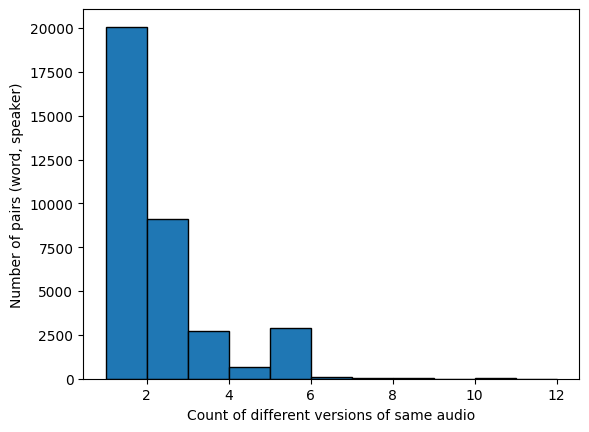

In [75]:
plt.hist(file_occurances, bins=11, edgecolor='black')
plt.ylabel('Number of pairs (word, speaker)')
plt.xlabel('Count of different versions of same audio')

In [73]:
values, bins = np.histogram(file_occurances, bins=11)
print(values)
print(bins)

[20073  9080  2726   668  2902    80    31    24     8    15     2]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]


(array([ 38.,   0.,  13.,   0.,  10.,   0.,  13.,   0.,   7.,   0.,  11.,
          0.,   8.,   0.,   7.,   0.,   6.,   0.,   7.,   0.,   8.,   0.,
          9.,   0.,   9.,   0.,  12.,   0.,  26.,   0.,   0.,  79.,   0.,
        162.,   0., 260.,   0., 385.,   0., 310.,   0., 223.,   0.,  88.,
          0.,  32.,   0.,   3.,   0.,   1.,   0.,   4.,   0.,   3.,   0.,
          1.,   0.,   9.,   0., 137.]),
 array([ 1.        ,  1.48333333,  1.96666667,  2.45      ,  2.93333333,
         3.41666667,  3.9       ,  4.38333333,  4.86666667,  5.35      ,
         5.83333333,  6.31666667,  6.8       ,  7.28333333,  7.76666667,
         8.25      ,  8.73333333,  9.21666667,  9.7       , 10.18333333,
        10.66666667, 11.15      , 11.63333333, 12.11666667, 12.6       ,
        13.08333333, 13.56666667, 14.05      , 14.53333333, 15.01666667,
        15.5       , 15.98333333, 16.46666667, 16.95      , 17.43333333,
        17.91666667, 18.4       , 18.88333333, 19.36666667, 19.85      ,
      

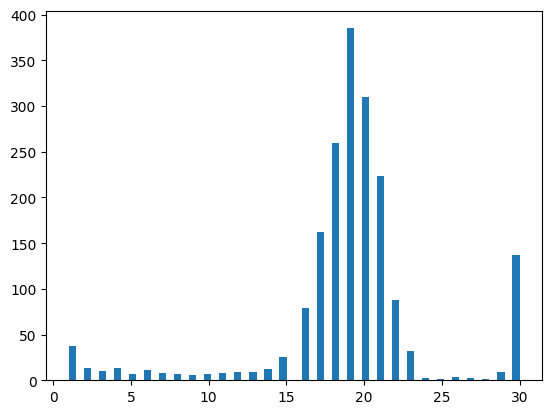

In [ ]:
files = glob.glob("../data/tsrc/train/**/*_nohash_0.wav", recursive=True)
word_speaker_to_files: Dict[str, List[str]] = {}

for file in files:
    hash_id = file.split("\\")[-1].split("_")[-3]
    if hash_id not in word_speaker_to_files:
        word_speaker_to_files[hash_id] = []
    word_speaker_to_files[hash_id].append(file)


file_occurances = [len(files) for files in word_speaker_to_files.values()]
plt.hist(file_occurances, bins=60)

In [ ]:
files = glob.glob("../data/tsrc_train_test/train/**/*_nohash_0.wav", recursive=True)
speaker_id_to_files: Dict[str, List[str]] = {}

for file in files:
    speaker_id = file.split("\\")[-1].split("_")[-3]
    if speaker_id not in speaker_id_to_files:
        speaker_id_to_files[speaker_id] = []
    speaker_id_to_files[speaker_id].append(file)


file_occurances = [len(files) for files in speaker_id_to_files.values()]
plt.hist(file_occurances, bins=int(sqrt(len(file_occurances))))

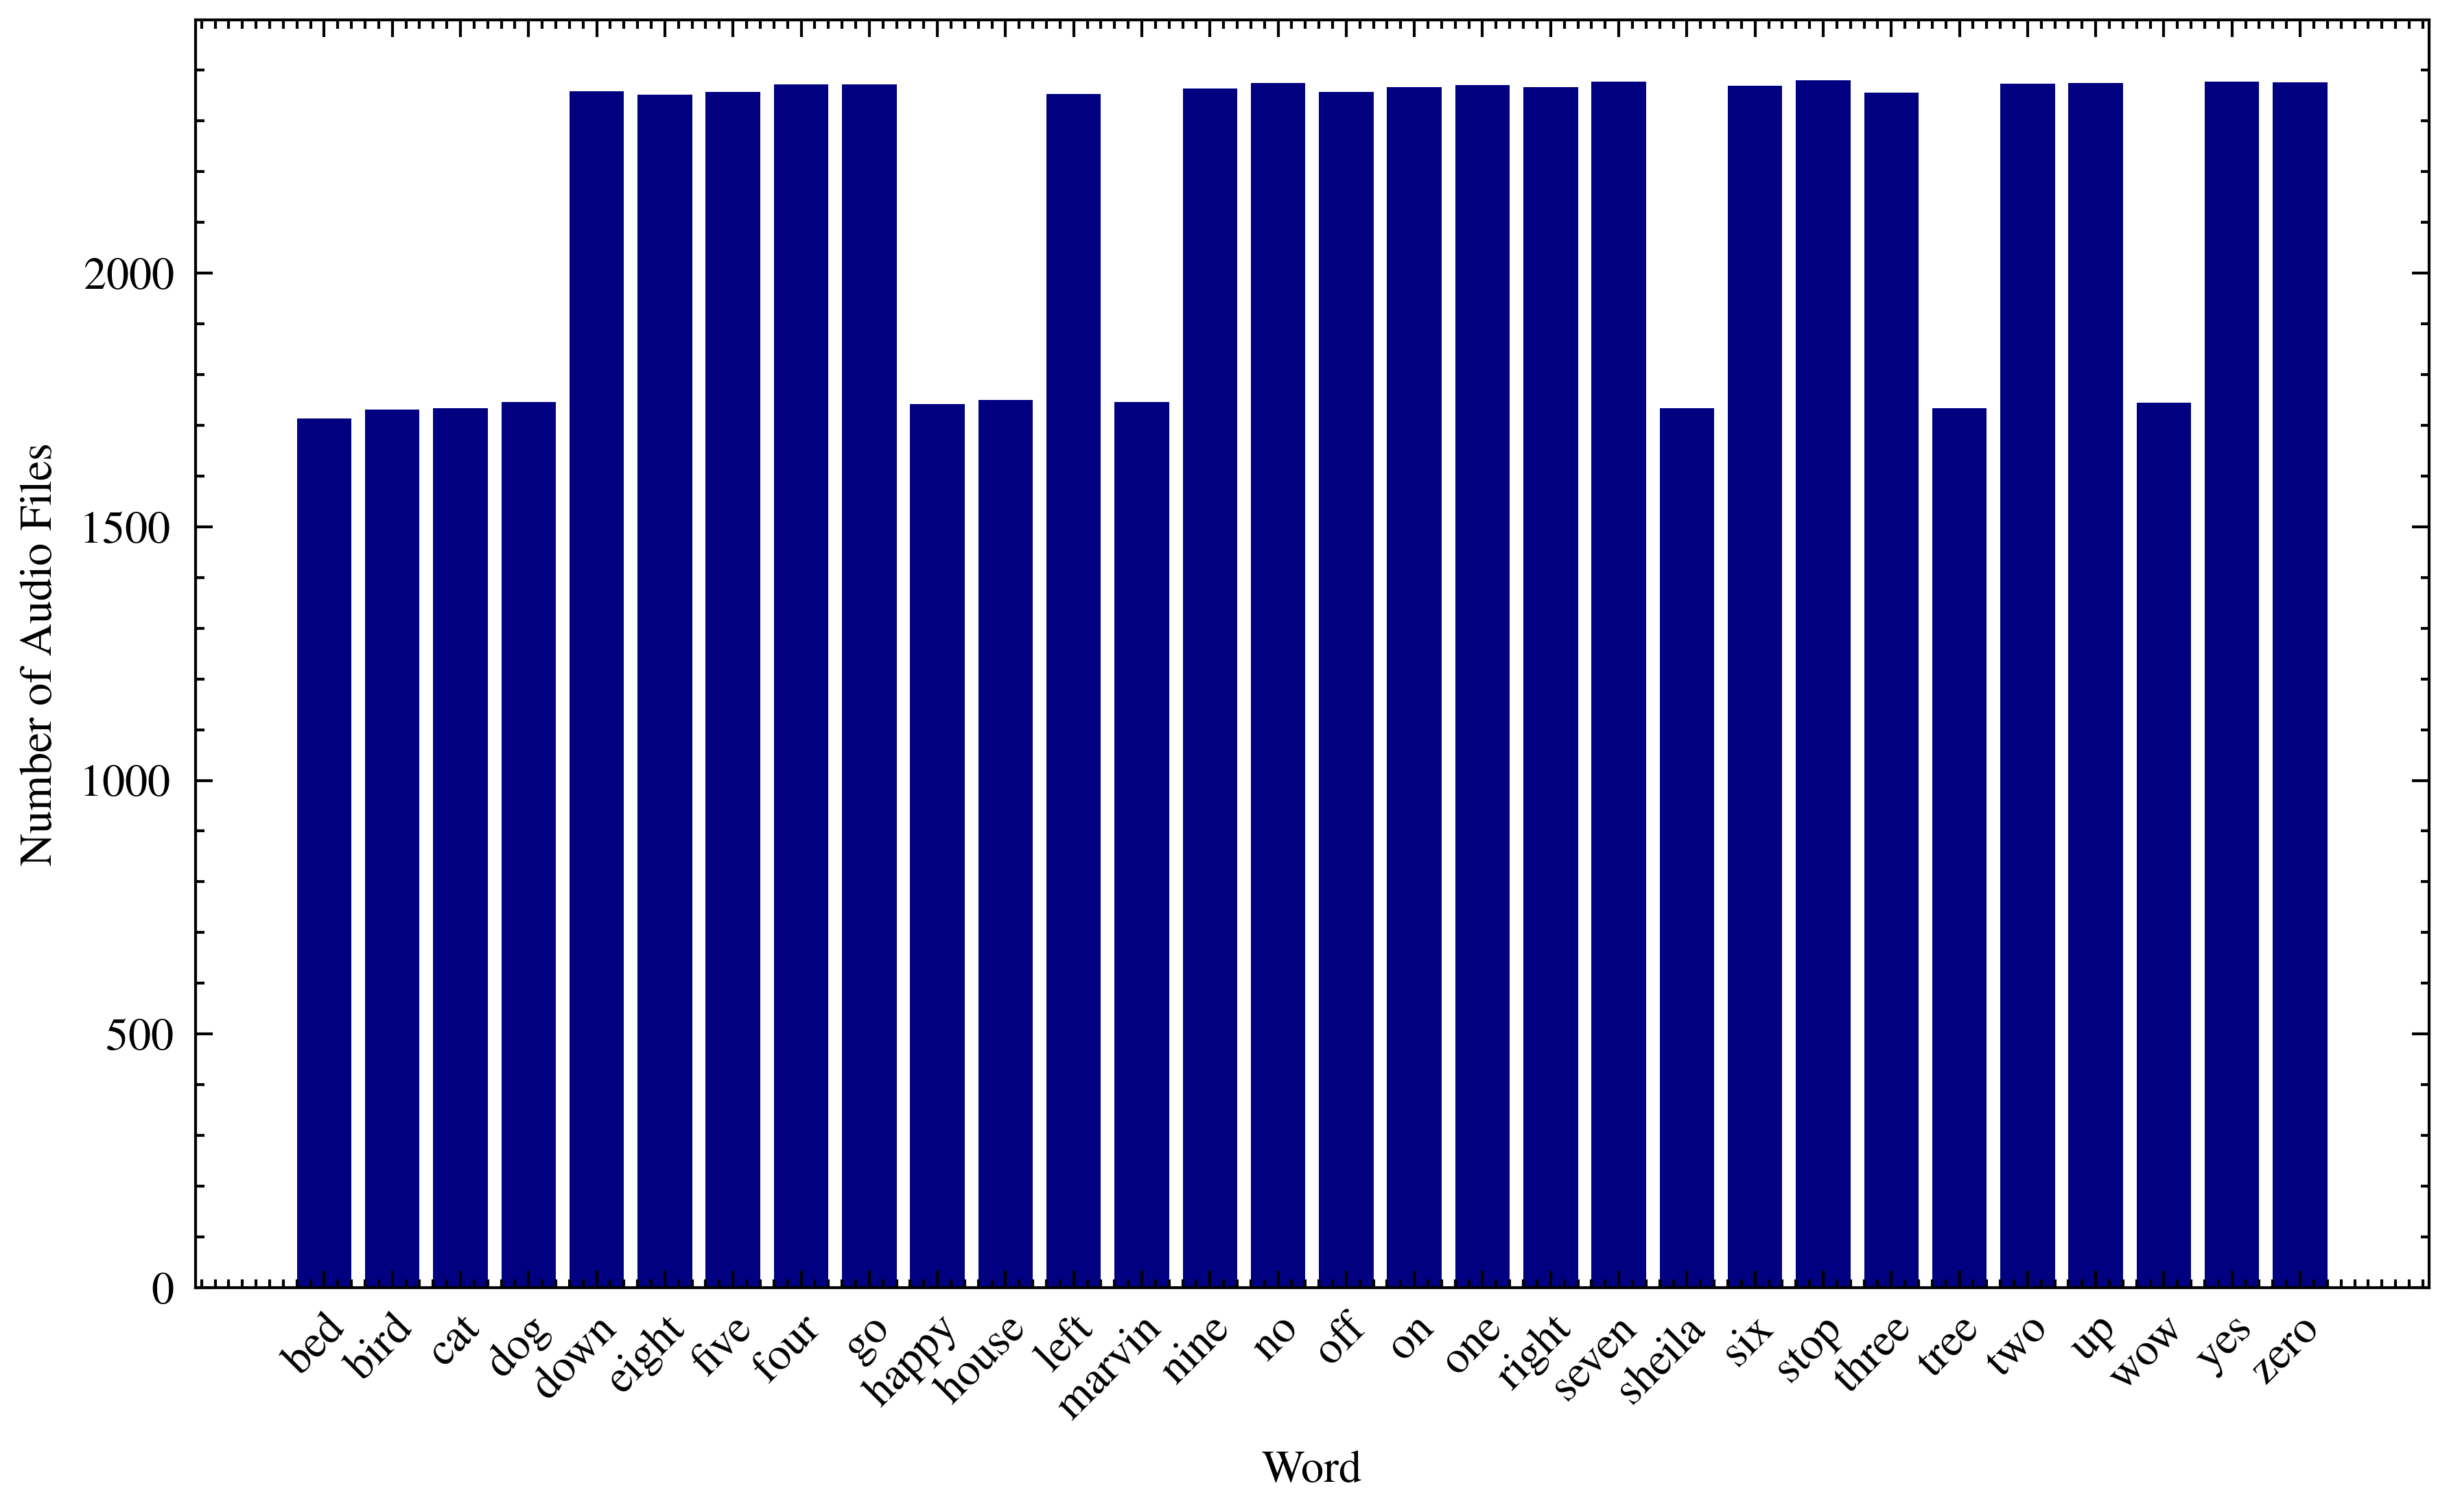

In [9]:
word_to_audio_files: Dict[str, List[str]] = {}

for word in os.listdir('../data/tsrc/train/audio'):
    if word == '_background_noise_':
        continue
    word_to_audio_files[word] = glob.glob(f"../data/tsrc/train/audio/{word}/*.wav")


file_occurances = [len(files) for files in word_to_audio_files.values()]

plt.figure(figsize=(7, 4))
plt.bar(word_to_audio_files.keys(), file_occurances, color='navy')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.ylabel('Number of Audio Files')
plt.xlabel('Word')
plt.savefig('charts/word_to_audio_files.png', bbox_inches='tight')
plt.show()

In [4]:
random.seed(42)
np.random.seed(42)

train_test_split(
    '../data/tsrc/train/audio', 
    '../data/tsrc_train_test', 
)
clean_audio_folder('../data/tsrc_train_test', '../data/tsrc_cleaned')

transformations = compose.Compose([
    (partial(audio.change_pitch, n_steps = [-4, -3, -2, -1, 1, 2, 3, 4]), 0.2),
    (partial(audio.dist_augm), 0.2),
    (partial(audio.addReverb), 0.2),
    (partial(audio.getFirstSyllable), 0.1)
])
audio.augment_audio_files('../data/tsrc_cleaned', '../data/tsrc_cleaned_augmented', transformations, 7000, 2500)

convert_audio_files_to_images("../data/tsrc_cleaned", "../data/tsrc_spectrograms_cleaned")
sharpen_spectrograms("../data/tsrc_spectrograms_cleaned", "../data/tsrc_spectrograms_cleaned_sharpened")

Loading audio files... ../data/tsrc_cleaned\train


0it [00:00, ?it/s]
100%|██████████| 1689/1689 [00:12<00:00, 133.70it/s]


Loading audio files... ../data/tsrc_cleaned\validation


0it [00:00, ?it/s]
100%|██████████| 160/160 [00:01<00:00, 135.19it/s]


Augmenting train
env:bed COUNT: 1125
wantedNoFilesPerClass : 7000, filesInEnv: 1125, augmentationRatio: 4.222222222222222
env:bird COUNT: 1183
wantedNoFilesPerClass : 7000, filesInEnv: 1183, augmentationRatio: 3.9171597633136095


p:\MINI8\I2ML\intro-to-ml\venv\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


env:cat COUNT: 1222
wantedNoFilesPerClass : 7000, filesInEnv: 1222, augmentationRatio: 3.728314238952537
env:dog COUNT: 1234
wantedNoFilesPerClass : 7000, filesInEnv: 1234, augmentationRatio: 3.672609400324149
env:down COUNT: 1659
wantedNoFilesPerClass : 7000, filesInEnv: 1659, augmentationRatio: 2.219409282700422
env:eight COUNT: 1635
wantedNoFilesPerClass : 7000, filesInEnv: 1635, augmentationRatio: 2.2813455657492354
env:five COUNT: 1646
wantedNoFilesPerClass : 7000, filesInEnv: 1646, augmentationRatio: 2.25273390036452
env:four COUNT: 1649
wantedNoFilesPerClass : 7000, filesInEnv: 1649, augmentationRatio: 2.2449969678593087
env:go COUNT: 1677
wantedNoFilesPerClass : 7000, filesInEnv: 1677, augmentationRatio: 2.1741204531902207
env:happy COUNT: 1252
wantedNoFilesPerClass : 7000, filesInEnv: 1252, augmentationRatio: 3.5910543130990416
env:house COUNT: 1248
wantedNoFilesPerClass : 7000, filesInEnv: 1248, augmentationRatio: 3.608974358974359
env:left COUNT: 1653
wantedNoFilesPerClass :

94it [01:06,  1.42it/s]


### Check if there is no data leakage

In [3]:
import glob 
from tqdm import tqdm

def parse_speaker_id(file_path: str) -> str:
    return file_path.split("\\")[-1].split("_")[0]

speakers_in_train = [parse_speaker_id(file) for file in glob.glob("../data/tsrc_augmented/train/**/*.wav", recursive=True)]

for file in tqdm(glob.glob("../data/tsrc_augmented/test/**/*.wav", recursive=True)):
    speaker_id = parse_speaker_id(file)
    if speaker_id in speakers_in_train:
        print(file)
    

100%|██████████| 15021/15021 [00:22<00:00, 654.32it/s]
